In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

%cd ../..

!hostname

/p/fastdata/pli/Private/oberstrass1/datasets/vervet1818-3d
jrlogin05.jureca


In [2]:
import os

import re
import pandas as pd
import numpy as np

import h5py as h5

import pli
import pli.image as im

from tqdm import tqdm

In [62]:
# Get mask and feature info

# model_name = "resnet50_planes8_sphere_small"
model_name = "resnet50_planes8_962-1083_sphere_small"
# model_name = "resnet50_planes8_962-1083_sphere"
# model_name = "resnet50_planes8_962-1083_neighbor"
# model_name = "resnet50_planes8_962-1083_circle"
# model_name = "resnet50_planes8_overlap"

centroids = 1024

kmeans_path = f"data/aa/clusters/kmeans_pca80_s1_{centroids}/{model_name}"
# kmeans_path = f"data/aa/clusters/kmeans_pca_s2_128/{model_name}"

# Group of the features in the H5 files
cluster_group = "Image"

###

p = re.compile('.*s([0-9]{4}).*h5')

feature_list = []
cluster_centers = None
for f in sorted(os.listdir(kmeans_path)):
    match = p.match(f)
    if match:
        id = int(match[1])
        cluster_section = pli.data.Section(path=os.path.join(kmeans_path, f))

        if 'cluster_centers' in cluster_section.attrs.keys():
            cluster_centers = cluster_section.attrs['cluster_centers']
        else:
            cluster_centers = cluster_section.handle.file['cluster_centers'][:]

        
        spacing = cluster_section.spacing
        origin = cluster_section.origin
        cluster_section.close_file_handle()
        feature_list.append({'id': id, 'spacing': spacing, 'origin': origin, 'file': os.path.join(kmeans_path, f)})
files_df = pd.DataFrame(feature_list)

files_df.head()

,id,spacing,origin,file
0,841,"(84.37760174274445, 84.37760174274445)","[0.0, 0.0]",data/aa/clusters/kmeans_pca80_s1_1024/resnet50...
1,842,"(84.37760174274445, 84.37760174274445)","[0.0, 0.0]",data/aa/clusters/kmeans_pca80_s1_1024/resnet50...
2,843,"(84.37760174274445, 84.37760174274445)","[0.0, 0.0]",data/aa/clusters/kmeans_pca80_s1_1024/resnet50...
3,844,"(84.37760174274445, 84.37760174274445)","[0.0, 0.0]",data/aa/clusters/kmeans_pca80_s1_1024/resnet50...
4,845,"(84.37760174274445, 84.37760174274445)","[0.0, 0.0]",data/aa/clusters/kmeans_pca80_s1_1024/resnet50...


In [63]:
# Perform smoothing

metric = 'euclidean' # 'euclidean'
linkage = 'ward'  # 'ward'

###

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

from vervet1818_3d.clustering import get_linkage_matrix

ac = AgglomerativeClustering(n_clusters=None, distance_threshold=0., affinity=metric, linkage=linkage)
ac.fit(cluster_centers)

linkage_matrix = get_linkage_matrix(ac)

In [64]:
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.family'] = 'sans-serif'

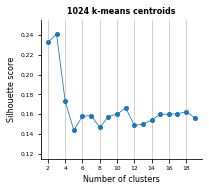

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Assuming cluster_centers is your feature matrix
# cluster_centers should be of shape (n_samples, n_features)

# Define a range of clusters to test
# num_clusters_range = range(2, 26)
num_clusters_range = range(2, 20)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

for num_clusters in num_clusters_range:
    threshold = linkage_matrix[-num_clusters, 2]
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    silhouette_avg = silhouette_score(cluster_centers, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores

fig, ax = plt.subplots(figsize=(2.895, 2.553))

ax.plot(num_clusters_range, silhouette_scores, marker='o', markersize=4)

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')

ax.set_xticks(range(2, 20, 2))
ax.set_ylim(0.12 - 0.005, 0.25 + 0.005)

# plt.vlines([3, 7, 14], ymin=min(silhouette_scores) - 0.005, ymax=max(silhouette_scores) + 0.005, linestyle='--', colors='black')

#ax.text(3, max(silhouette_scores) + 0.006, f'3', ha='center', va='bottom', weight='bold')
#ax.text(7, max(silhouette_scores) + 0.006, f'7', ha='center', va='bottom', weight='bold')
#ax.text(14, max(silhouette_scores) + 0.006, f'14', ha='center', va='bottom', weight='bold')

ax.grid(axis='x', linestyle='-', alpha=0.7)

plt.title(f"{centroids} k-means centroids")

plt.savefig(f"doc/clusters/k-means_{centroids}.pdf")
plt.savefig(f"doc/clusters/k-means_{centroids}.svg")

plt.show()

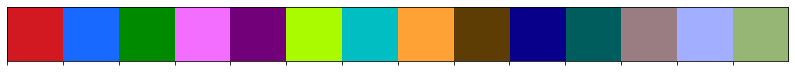

In [7]:
n_cluster = [3, 7, 14]
# n_cluster = [2, 5, 9]

import glasbey
import seaborn as sns

color_palette = glasbey.create_palette(palette_size=n_cluster[-1])
#color_palette = glasbey.extend_palette(
#    "tab10",
#    palette_size=max(n_cluster),
#    colorblind_safe=True,
#    # cvd_severity=100
#)
sns.palplot(color_palette)

In [8]:
# Perform clustering

from matplotlib.cm import register_cmap
from matplotlib.colors import LinearSegmentedColormap

cmap = 'test'

# Register the colormap with a name (e.g., 'custom_cmap')
try:
    plt.register_cmap(cmap=LinearSegmentedColormap.from_list(cmap, color_palette, N=len(color_palette)))
except:
    pass

cmap_max = 14

###

# Create clusterings

from scipy.cluster.hierarchy import dendrogram
from vervet1818_3d.clustering import index_to_color

cluster_dict = {}
for k in n_cluster:
    threshold = linkage_matrix[-k, 2]
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    cluster_dict[k] = cluster_labels

colors = cluster_dict[n_cluster[-1]].copy()


def llf(ix):
    return index_to_color(ix, colors, linkage_matrix)

def lcf(ix):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    color_ix = index_to_color(ix, colors, linkage_matrix) - 1

    c = mcolors.to_hex(color_palette[color_ix])

    return c

for k, clusters in cluster_dict.items():
    results_dict = dendrogram(linkage_matrix, no_plot=True, leaf_label_func=llf, truncate_mode="lastp", p=int(k), show_leaf_counts=False)
    cluster_dict[k] = np.take(results_dict['ivl'], cluster_dict[k] - 1)

/tmp/ipykernel_26266/3752752256.py:10: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=LinearSegmentedColormap.from_list(cmap, color_palette, N=len(color_palette)))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

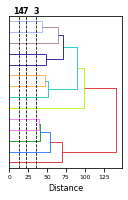

In [9]:
# Plot the corresponding dendrogram

show_cluster = 14
# show_cluster = 9

###

plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['lines.linewidth'] = .8

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(2.017, 2.798))
results_dict = dendrogram(linkage_matrix, link_color_func=lcf, leaf_label_func=llf, orientation='right', no_labels=True, truncate_mode="lastp", p=show_cluster, show_leaf_counts=False)
plt.xlabel('Distance')
# plt.title('Dendrogram')
plt.text(36, 140, f'3', ha='center', va='bottom', weight='bold')
plt.text(22, 140, f'7', ha='center', va='bottom', weight='bold')
plt.text(13, 140, f'14', ha='center', va='bottom', weight='bold')

plt.vlines([36, 22, 13.], ymin=0, ymax=400, linestyle='--', colors='black')
# plt.savefig(f"tmp/dengrogram_{model_name}.svg")

# Create a colormap from the specified palette
sm = ScalarMappable(cmap=cmap)
cbar = plt.colorbar(sm, orientation='vertical', location='left', pad=0.)
cbar.set_ticks(np.linspace(1/(2*show_cluster), 1 + 1/(2*show_cluster), show_cluster+1))
cbar.set_ticklabels([str(i) for i in range(1, show_cluster+1)])

#plt.savefig("doc/clusters/agglomerative-sphere_small-dendogram.png")
#plt.savefig("doc/clusters/agglomerative-sphere_small-dendogram.svg")

plt.show()

Use data/aa/clusters/kmeans_pca80_s1_1024/resnet50_planes8_962-1083_sphere_small/Kmeans_1024_s0961.h5
Warning! Printing mask for non integer like array


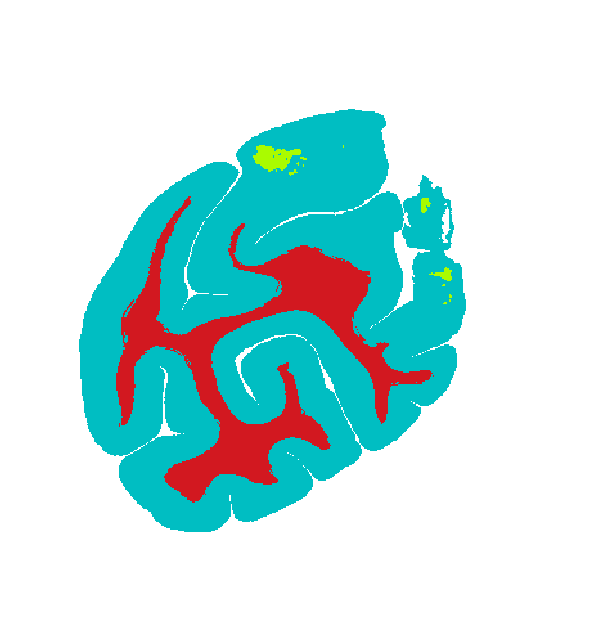

Warning! Printing mask for non integer like array


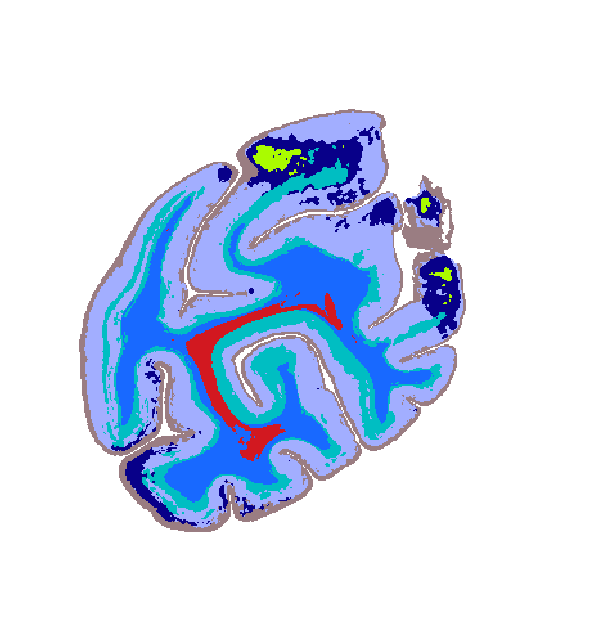

Warning! Printing mask for non integer like array


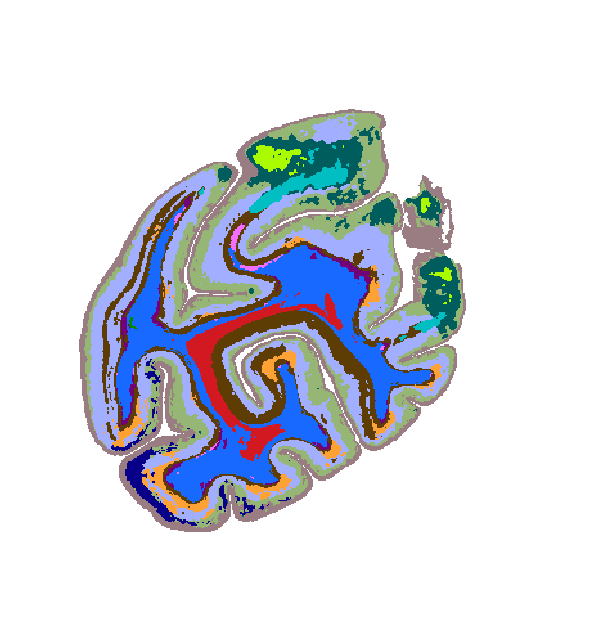

In [10]:
test_ix = 115

###

# Select test file
file = files_df.loc[test_ix].file
print("Use", file)

# Load test clusters and mask
test_section = pli.data.Section(path=file)
test_clusters = np.rot90(test_section.image[:], k=3)
test_mask = test_clusters > 0

# Map clusters

for n in n_cluster:
    print_clusters = test_clusters.copy()
    print_clusters[test_mask] = cluster_dict[n][test_clusters[test_mask] - 1]

    # Show mapped clusters
    im.show(print_clusters, mask=~test_mask, cmap=cmap, mask_map='gray_r', alpha=1.0, interpolation='nearest', size=8, scale=False, vmin=1, vmax=cmap_max)

In [10]:
# Map clustering to new sections

out_folder = f"data/aa/clusters/agglomerative"
out_modality = 'Mask'

# Out parameters
chunk_size = 128
compression ='gzip'

###

for n in cluster_dict.keys():
    # Create masks
    out_path = os.path.join(out_folder + f"_{n}", model_name)

    if not os.path.exists(out_path):
        print("Create path", out_path)
        os.makedirs(out_path, exist_ok=True)

    print("Write cluster sections to", out_path)
    for k, r in tqdm(files_df.iterrows(), total=len(files_df)):
        cluster_section = pli.data.Section(path=r.file)
        section_clusters = cluster_section.image[:]
        test_mask = section_clusters > 0
        section_clusters[test_mask] =  cluster_dict[n][section_clusters[test_mask] - 1]
        section_clusters = section_clusters.astype(np.uint8)

        out_file = f"Agglomerative_{n}_s{r.id:04d}.h5"
        out_section = pli.data.Section(image=section_clusters)
        out_section.spacing = r.spacing
        out_section.origin = r.origin
        out_section.maximum = 10
        out_section.minimum = 1
        out_section.modality = out_modality
        out_section.attrs['n_mappings'] = n

        out_section.to_hdf5(
            os.path.join(out_path, out_file),
            chunk_size=chunk_size,
            compression=compression,
            pyramid=False,
            overwrite=True
        )
        out_section.close_file_handle()

Write cluster sections to data/aa/clusters/agglomerative_3/resnet50_planes8_962-1083_sphere_small


100%|██████████| 116/116 [00:03<00:00, 37.73it/s]


Write cluster sections to data/aa/clusters/agglomerative_7/resnet50_planes8_962-1083_sphere_small


100%|██████████| 116/116 [00:02<00:00, 39.30it/s]


Write cluster sections to data/aa/clusters/agglomerative_14/resnet50_planes8_962-1083_sphere_small


100%|██████████| 116/116 [00:02<00:00, 46.63it/s]
